In [ ]:
import pandas as pd

url = "https://gksmyth.github.io/ozdasl/oz/stroke.txt"
df = pd.read_csv(url, sep='\t')

print(df)

   Subject Group Sex Side  Age  Lapse  UE1  UE2  UE3  UE4  ...  Bal7  Bal8  \
0        I     E   M    R   74  11.00   15   23   23   26  ...    10    10   
1       II     E   M    L   61   2.00    3    3    3    5  ...     8     8   
2      III     E   M    R   49   6.00    2    2    4    7  ...    10    10   
3       IV     E   M    L   68   1.00   14   25   25   31  ...     9     9   
4        V     E   M    R   55  33.00   22   22   22   22  ...    12    12   
5       VI     E   M    L   64   0.29    5   14   16   26  ...     9     9   
6      VII     E   M    L   59   5.00    1    3    4    5  ...     9     9   
7     VIII     E   M    R   62   0.43    2    2    3    4  ...    10    10   
8        1     F   M    R   58   1.00    4    4    4    4  ...    11    11   
9        2     F   M    R   41   4.00   17   22   22   22  ...    12    12   
10       3     F   M    R   63   4.00   36   36   27   26  ...    12    12   
11       4     F   M    L   67   1.00    2    3    3    9  ...  

In [ ]:
import pymc as pm
import pandas as pd
import numpy as np

df['Sex_code'] = df['Sex'].replace({'M': 0, 'F': 1})
df['Side_code'] = df['Side'].replace({'L': 0, 'R': 1})

long_df = pd.wide_to_long(df, stubnames=['UE', 'HW', 'LE', 'Bal', 'Bart'], i='Subject', j='Week').reset_index()
long_df


Subject  Week Sex Group  Side_code Side  Lapse  Sex_code  Age  UE  HW  LE  \
0         I     1   M     E          1    R   11.0         0   74  15   4  20   
1        II     1   M     E          0    L    2.0         0   61   3   0   2   
2       III     1   M     E          1    R    6.0         0   49   2   0   4   
3        IV     1   M     E          0    L    1.0         0   68  14   5   7   
4         V     1   M     E          1    R   33.0         0   55  22   0  20   
..      ...   ...  ..   ...        ...  ...    ...       ...  ...  ..  ..  ..   
187       D     8   M     G          1    R    1.0         0   69  28  16  21   
188       E     8   M     G          1    R    7.0         0   59  36  24  25   
189       F     8   F     G          0    L    2.0         1   76   8   0  13   
190       G     8   F     G          0    L    2.0         1   75   6   0   9   
191       H     8   F     G          1    R    2.0         1   56   8   0  17   

     Bal  Bart  
0      8    45  
1      2    20  
2      4    50  
3      1    25  
4     10   100  
..   ...   ...  
187   11   100  
188   11   100  
189    5    40  
190    4    40  
191    9    65  

[192 rows x 14 columns]

# UE Score

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
group_effect[0]     2.08   6.31   -9.97    14.21       0.21     0.15   
group_effect[1]     0.77   6.40  -11.90    12.36       0.19     0.13   
group_effect[2]    -1.52   7.01  -14.89    10.97       0.20     0.15   
mu_alpha            1.97   8.96  -14.42    18.73       0.77     0.55   
alpha_subject[0]   -1.58  11.09  -24.82    16.67       0.73     0.52   
alpha_subject[1]    6.94  10.72  -13.07    26.80       0.69     0.48   
alpha_subject[2]   10.75  11.27  -11.34    31.61       0.78     0.55   
alpha_subject[3]   -1.97  10.00  -21.19    16.88       0.79     0.56   
alpha_subject[4]   -0.18  11.19  -21.99    19.53       0.76     0.54   
alpha_subject[5]   -4.46  10.45  -24.09    15.37       0.86     0.61   
alpha_subject[6]   -0.85  11.82  -23.58    20.74       0.83     0.59   
alpha_subject[7]    7.84  10.86  -13.56    27.46       0.89     0.63   
alpha_subject[8]   -3.43  10.71  -24.48    15.87       0.84     

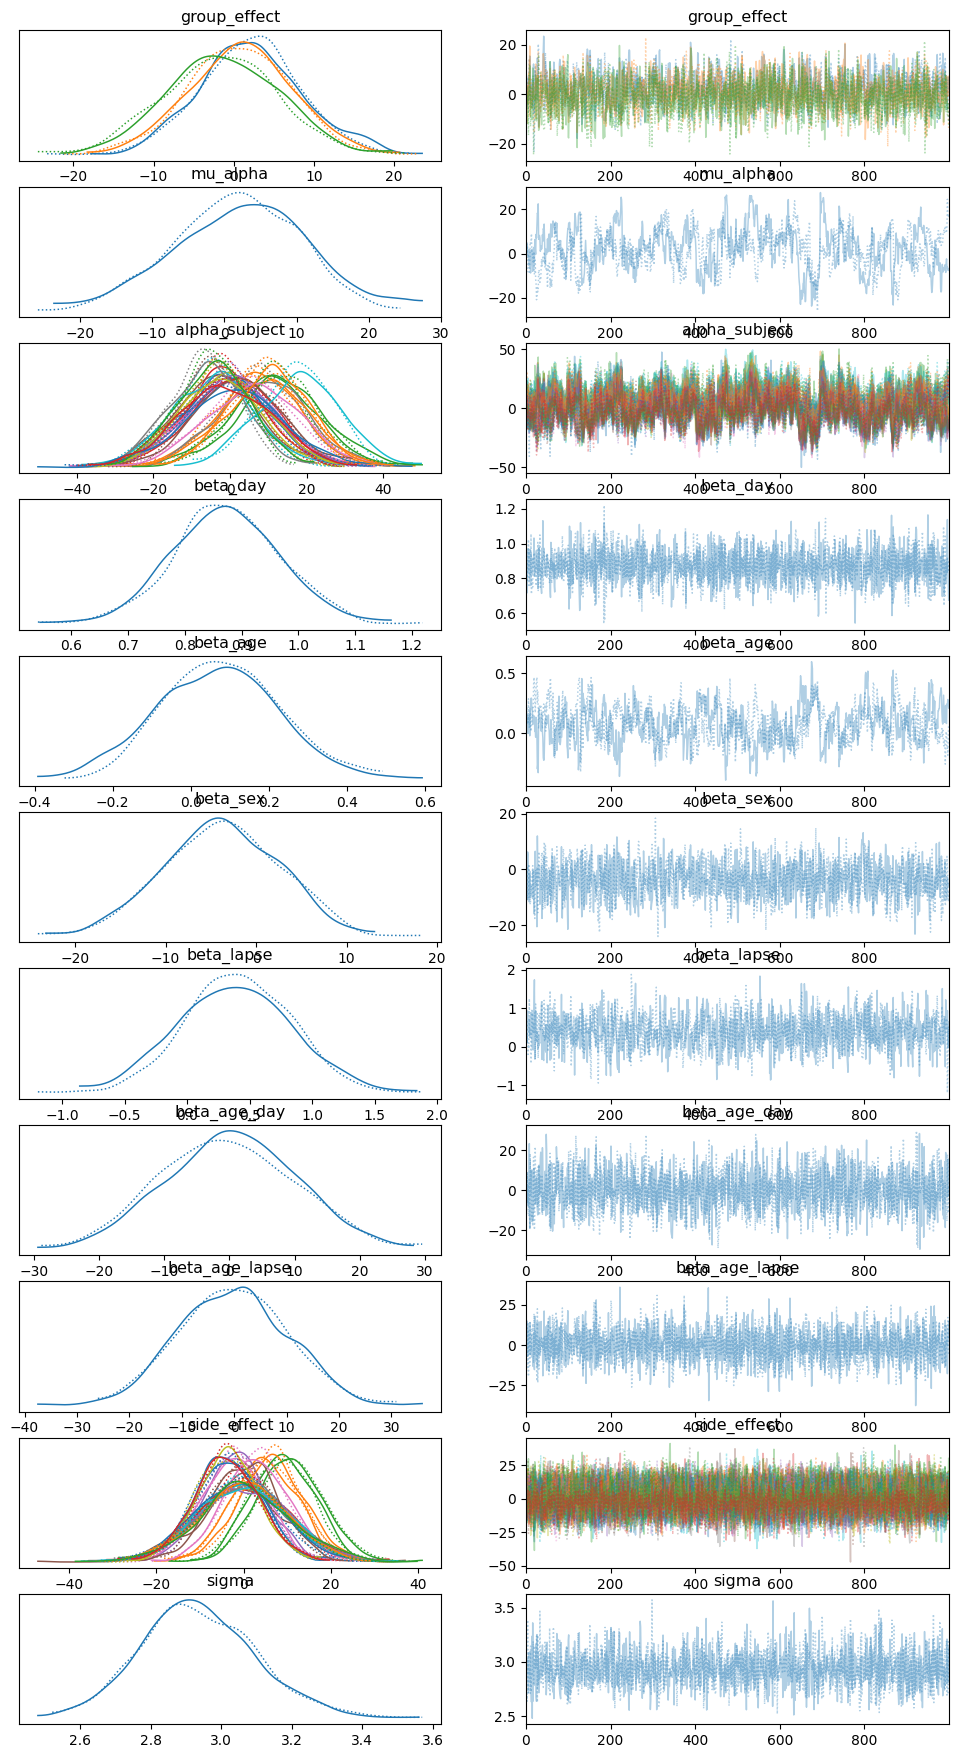

In [ ]:
# 为模型中使用的变量定义一些索引变量
subject_idx = long_df['Subject'].astype('category').cat.codes.values

ue_scores = long_df['UE'].values

n_subjects = len(long_df['Subject'].unique())

long_df['Group_code'] = long_df['Group'].astype('category').cat.codes.values
n_groups = long_df['Group'].nunique()

with pm.Model() as hierarchical_model_UE:

    # 定义共享数据容器
    subject_idx = pm.MutableData('subject_idx', long_df['Subject'].astype('category').cat.codes.values)
    age = pm.MutableData('age', long_df['Age'].values)
    week = pm.MutableData('week', long_df['Week'].values)
    sex = pm.MutableData('sex', long_df['Sex_code'].values)
    side_code = pm.MutableData('side_code', long_df['Side_code'].values)
    lapse = pm.MutableData('lapse', long_df['Lapse'].values)

    group_effect = pm.Normal('group_effect', mu=0, sigma=10, shape=n_groups)
    #group_idx = pm.Data('group_idx', long_df['Group_code'].values)
    group_idx = pm.MutableData('group_idx', long_df['Group_code'].values)
    # 全局截距的先验
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=10)

    # 每个病人截距的随机效应
    alpha_subject = pm.Normal('alpha_subject', mu=mu_alpha, sigma=10, shape=n_subjects)

    # 固定效应的斜率先验
    beta_day = pm.Normal('beta_day', mu=0, sigma=10)
    beta_age = pm.Normal('beta_age', mu=0, sigma=10)
    beta_sex = pm.Normal('beta_sex', mu=0, sigma=10)
    beta_lapse = pm.Normal('beta_lapse', mu=0, sigma=10)

    beta_age_day = pm.Normal('beta_age_day', mu=0, sigma=10)
    beta_age_lapse = pm.Normal('beta_age_lapse', mu=0, sigma=10)

    # 对每个病人截距的随机效应进行调整
    alpha_adjusted = alpha_subject[subject_idx] + pm.Normal('side_effect', mu=0, sigma=10, shape=n_subjects)[subject_idx] * side_code

    # 模型的期望值
    mu = alpha_adjusted + beta_day * week +  beta_sex * sex + beta_lapse * lapse + beta_age * age + group_effect[group_idx]

    # 观测的似然
    sigma = pm.HalfCauchy('sigma', beta=2)

    # change
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=ue_scores)

    # 后验采样
    UE_trace = pm.sample(1000, return_inferencedata=True)

import arviz as az

# 使用转换后的InferenceData进行可视化和分析
az.plot_trace(UE_trace)
UE_posterior_summary = az.summary(UE_trace, round_to=2)
print(UE_posterior_summary)

                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
group_effect[0]     6.87   6.26   -5.00    18.54       0.14     0.11   
group_effect[1]     4.73   6.48   -8.00    16.27       0.14     0.12   
group_effect[2]     4.00   6.95   -8.94    16.72       0.14     0.14   
mu_alpha           17.05   8.65   -0.00    32.04       0.61     0.43   
alpha_subject[0]   30.98  11.02   12.07    53.27       0.62     0.44   
alpha_subject[1]   28.93  10.58   10.69    49.14       0.56     0.40   
alpha_subject[2]   22.16  11.20    1.10    43.94       0.65     0.46   
alpha_subject[3]   13.94  10.15   -4.60    32.79       0.65     0.46   
alpha_subject[4]   23.54  11.21    2.59    43.32       0.60     0.43   
alpha_subject[5]  -12.12  10.61  -31.35     7.93       0.69     0.49   
alpha_subject[6]   18.30  11.75   -2.18    41.26       0.65     0.46   
alpha_subject[7]   15.66  10.90   -5.22    35.65       0.72     0.51   
alpha_subject[8]    3.77  10.36  -15.46    22.61       0.66     

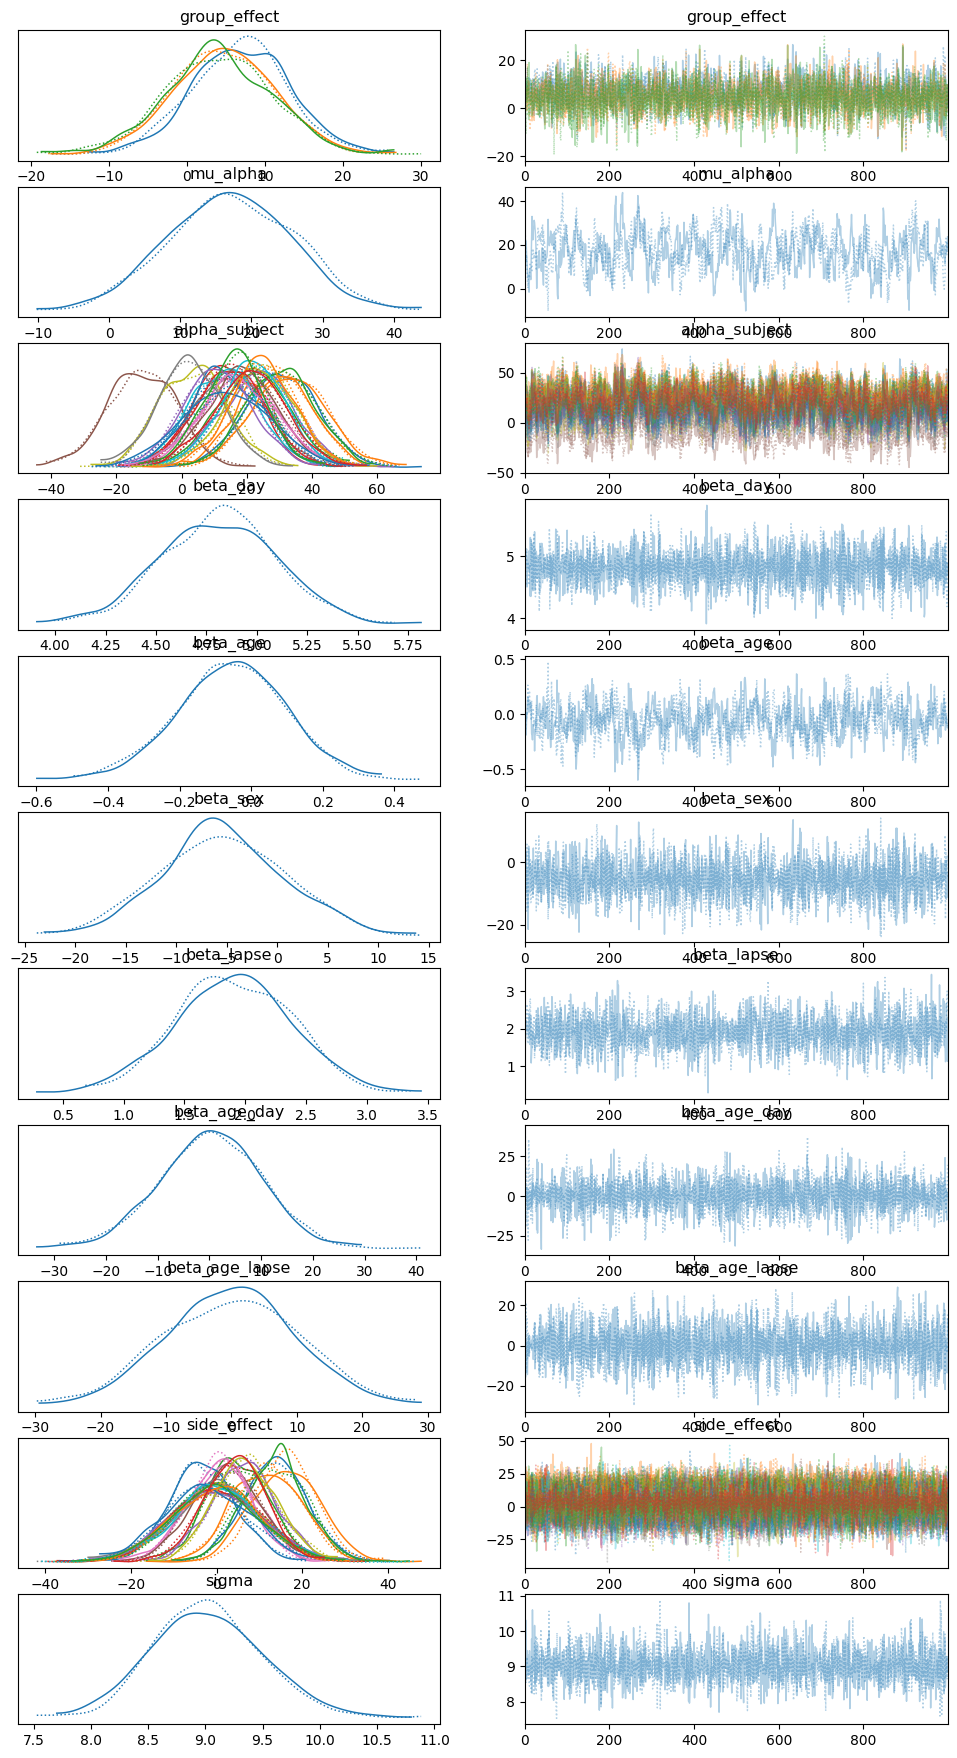

In [ ]:
# 为模型中使用的变量定义一些索引变量
subject_idx = long_df['Subject'].astype('category').cat.codes.values

Bart_scores = long_df['Bart'].values

n_subjects = len(long_df['Subject'].unique())

long_df['Group_code'] = long_df['Group'].astype('category').cat.codes.values
n_groups = long_df['Group'].nunique()

with pm.Model() as hierarchical_model_Bart:

    # 定义共享数据容器
    subject_idx = pm.MutableData('subject_idx', long_df['Subject'].astype('category').cat.codes.values)
    age = pm.MutableData('age', long_df['Age'].values)
    week = pm.MutableData('week', long_df['Week'].values)
    sex = pm.MutableData('sex', long_df['Sex_code'].values)
    side_code = pm.MutableData('side_code', long_df['Side_code'].values)
    lapse = pm.MutableData('lapse', long_df['Lapse'].values)

    group_effect = pm.Normal('group_effect', mu=0, sigma=10, shape=n_groups)
    #group_idx = pm.Data('group_idx', long_df['Group_code'].values)
    group_idx = pm.MutableData('group_idx', long_df['Group_code'].values)
    # 全局截距的先验
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=10)

    # 每个病人截距的随机效应
    alpha_subject = pm.Normal('alpha_subject', mu=mu_alpha, sigma=10, shape=n_subjects)

    # 固定效应的斜率先验
    beta_day = pm.Normal('beta_day', mu=0, sigma=10)
    beta_age = pm.Normal('beta_age', mu=0, sigma=10)
    beta_sex = pm.Normal('beta_sex', mu=0, sigma=10)
    beta_lapse = pm.Normal('beta_lapse', mu=0, sigma=10)

    beta_age_day = pm.Normal('beta_age_day', mu=0, sigma=10)
    beta_age_lapse = pm.Normal('beta_age_lapse', mu=0, sigma=10)

    # 对每个病人截距的随机效应进行调整
    alpha_adjusted = alpha_subject[subject_idx] + pm.Normal('side_effect', mu=0, sigma=10, shape=n_subjects)[subject_idx] * side_code

    # 模型的期望值
    mu = alpha_adjusted + beta_day * week +  beta_sex * sex + beta_lapse * lapse + beta_age * age + group_effect[group_idx]

    # 观测的似然
    sigma = pm.HalfCauchy('sigma', beta=2)

    # change
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=Bart_scores)

    # 后验采样
    Bart_trace = pm.sample(1000, return_inferencedata=True)

import arviz as az

# 使用转换后的InferenceData进行可视化和分析
az.plot_trace(Bart_trace)
Bart_posterior_summary = az.summary(Bart_trace, round_to=2)
print(Bart_posterior_summary)

                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
group_effect[0]     1.95   6.23   -9.68    13.51       0.14     0.15   
group_effect[1]     2.62   6.48   -9.30    14.68       0.15     0.15   
group_effect[2]    -0.99   7.08  -13.54    12.98       0.16     0.18   
mu_alpha            3.12   9.46  -14.41    21.49       0.71     0.51   
alpha_subject[0]    4.99  11.42  -15.39    26.97       0.67     0.47   
alpha_subject[1]    7.41  10.82  -13.55    27.20       0.60     0.43   
alpha_subject[2]    7.45  11.85  -14.06    29.48       0.71     0.50   
alpha_subject[3]   -0.75  10.38  -19.56    19.87       0.71     0.51   
alpha_subject[4]    5.51  11.33  -15.98    26.30       0.64     0.46   
alpha_subject[5]   -4.85  10.87  -25.27    15.37       0.76     0.54   
alpha_subject[6]    2.98  12.23  -20.10    25.29       0.72     0.51   
alpha_subject[7]    5.49  11.34  -16.47    25.75       0.80     0.57   
alpha_subject[8]   -1.30  11.14  -23.77    19.05       0.76     

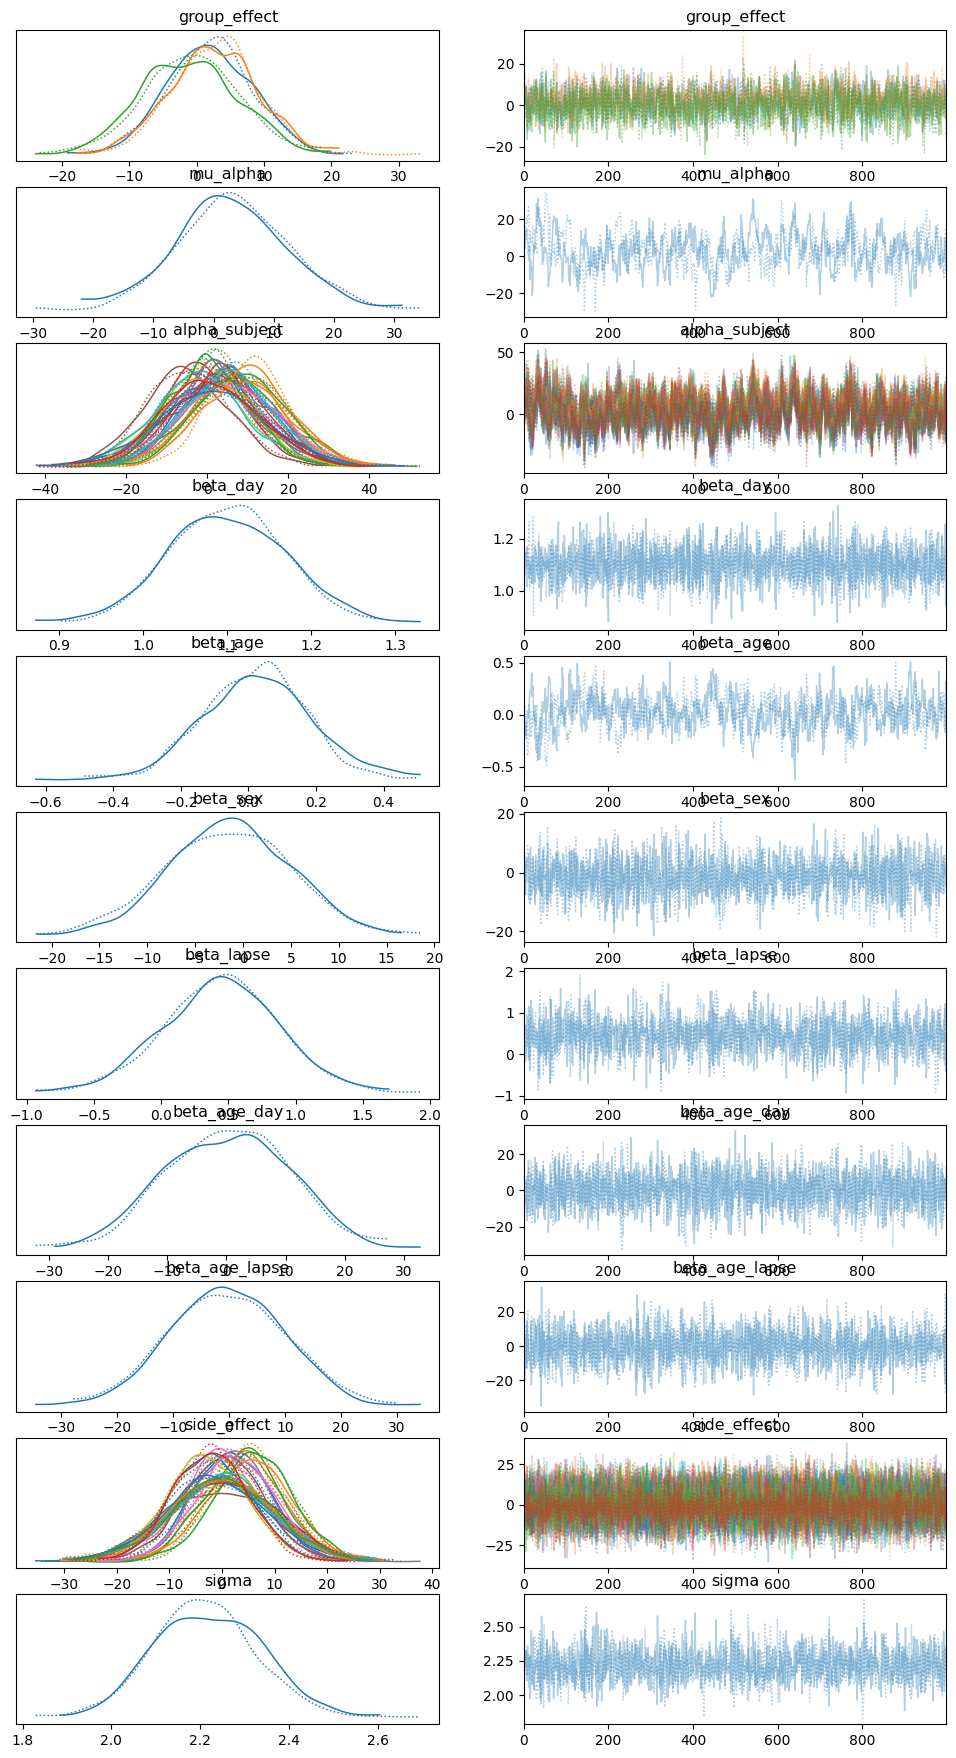

In [ ]:
# 为模型中使用的变量定义一些索引变量
subject_idx = long_df['Subject'].astype('category').cat.codes.values

LE_scores = long_df['LE'].values

n_subjects = len(long_df['Subject'].unique())

long_df['Group_code'] = long_df['Group'].astype('category').cat.codes.values
n_groups = long_df['Group'].nunique()

with pm.Model() as hierarchical_model_LE:

    # 定义共享数据容器
    subject_idx = pm.MutableData('subject_idx', long_df['Subject'].astype('category').cat.codes.values)
    age = pm.MutableData('age', long_df['Age'].values)
    week = pm.MutableData('week', long_df['Week'].values)
    sex = pm.MutableData('sex', long_df['Sex_code'].values)
    side_code = pm.MutableData('side_code', long_df['Side_code'].values)
    lapse = pm.MutableData('lapse', long_df['Lapse'].values)

    group_effect = pm.Normal('group_effect', mu=0, sigma=10, shape=n_groups)
    #group_idx = pm.Data('group_idx', long_df['Group_code'].values)
    group_idx = pm.MutableData('group_idx', long_df['Group_code'].values)
    # 全局截距的先验
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=10)

    # 每个病人截距的随机效应
    alpha_subject = pm.Normal('alpha_subject', mu=mu_alpha, sigma=10, shape=n_subjects)

    # 固定效应的斜率先验
    beta_day = pm.Normal('beta_day', mu=0, sigma=10)
    beta_age = pm.Normal('beta_age', mu=0, sigma=10)
    beta_sex = pm.Normal('beta_sex', mu=0, sigma=10)
    beta_lapse = pm.Normal('beta_lapse', mu=0, sigma=10)

    beta_age_day = pm.Normal('beta_age_day', mu=0, sigma=10)
    beta_age_lapse = pm.Normal('beta_age_lapse', mu=0, sigma=10)

    # 对每个病人截距的随机效应进行调整
    alpha_adjusted = alpha_subject[subject_idx] + pm.Normal('side_effect', mu=0, sigma=10, shape=n_subjects)[subject_idx] * side_code

    # 模型的期望值
    mu = alpha_adjusted + beta_day * week +  beta_sex * sex + beta_lapse * lapse + beta_age * age + group_effect[group_idx]

    # 观测的似然
    sigma = pm.HalfCauchy('sigma', beta=2)

    # change
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=LE_scores)

    # 后验采样
    LE_trace = pm.sample(1000, return_inferencedata=True)

import arviz as az

# 使用转换后的InferenceData进行可视化和分析
az.plot_trace(LE_trace)
LE_posterior_summary = az.summary(LE_trace, round_to=2)
print(LE_posterior_summary)

                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
group_effect[0]    1.21   6.33  -11.12    12.65       0.22     0.15    851.60   
group_effect[1]    1.36   6.60  -11.03    13.62       0.24     0.17    748.33   
group_effect[2]    0.30   7.20  -12.95    13.43       0.24     0.17    918.68   
mu_alpha           1.94   9.28  -15.03    18.76       0.77     0.55    144.73   
alpha_subject[0]   3.27  11.57  -19.16    23.86       0.79     0.56    212.32   
alpha_subject[1]   4.62  10.78  -15.46    24.33       0.67     0.47    259.87   
alpha_subject[2]   3.74  11.86  -18.41    25.70       0.86     0.61    191.88   
alpha_subject[3]   0.36  10.30  -18.14    19.54       0.83     0.59    154.84   
alpha_subject[4]   2.71  11.18  -18.16    23.37       0.77     0.54    214.14   
alpha_subject[5]  -3.36  10.79  -22.56    16.45       0.88     0.62    150.75   
alpha_subject[6]   2.22  12.23  -19.55    24.98       0.83     0.59    218.47   
alpha_subject[7]   2.43  11.

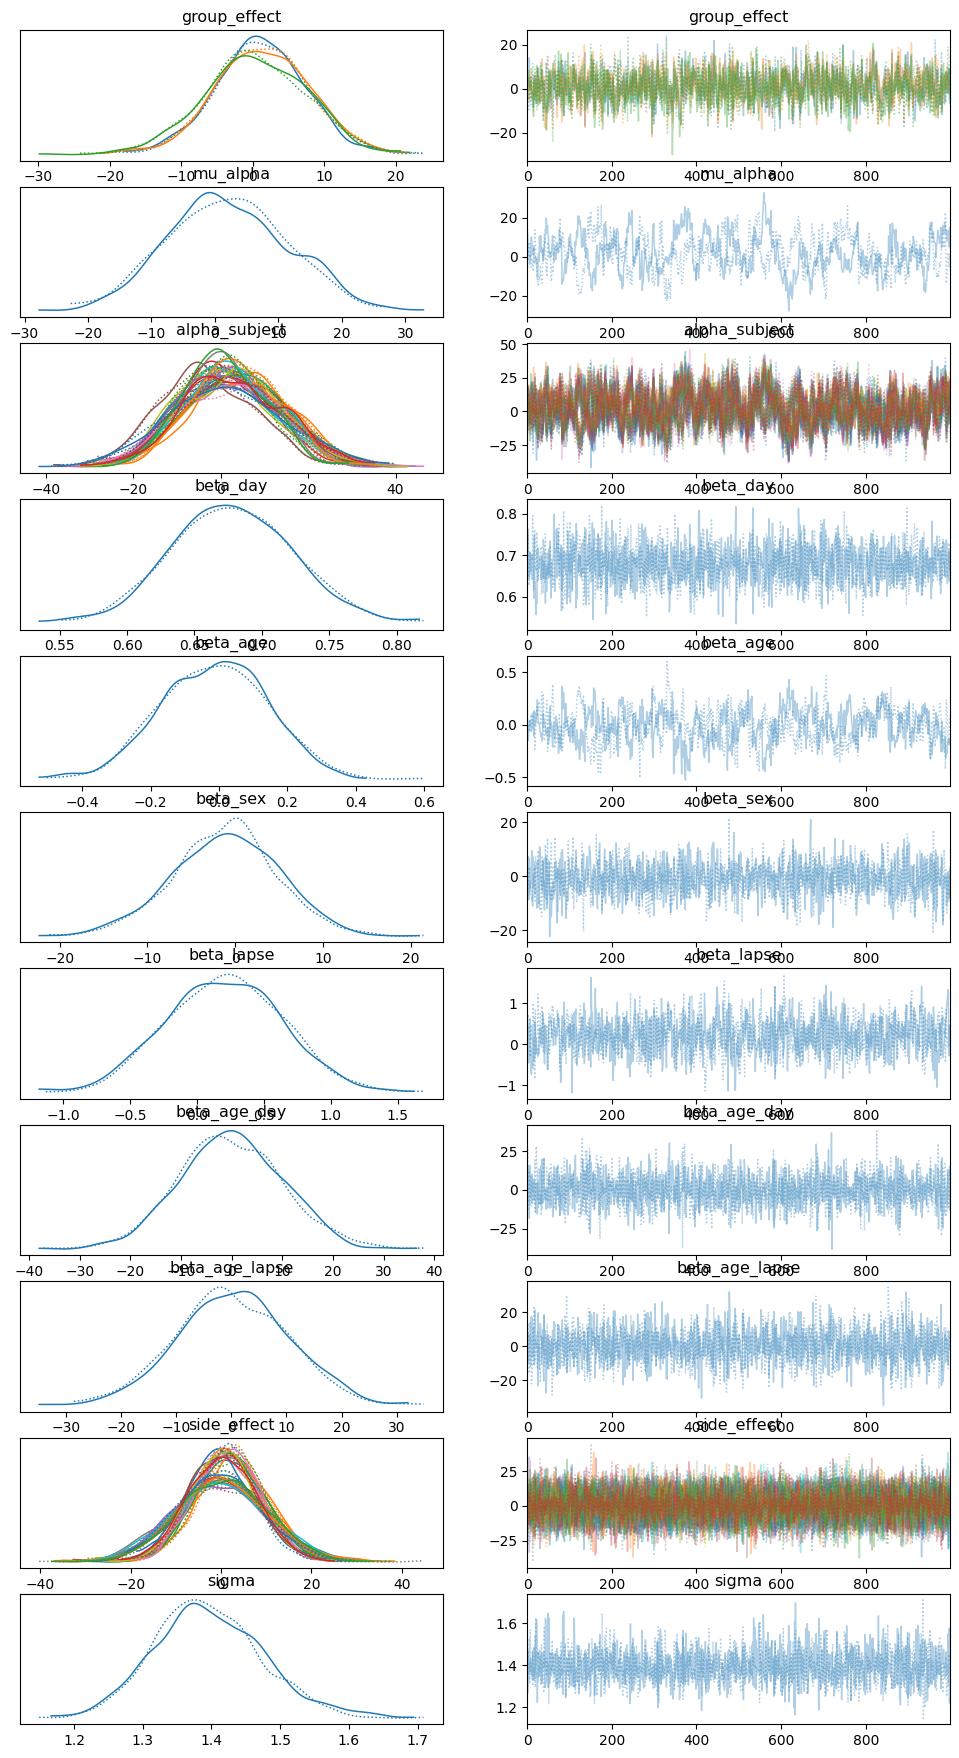

In [ ]:
# 为模型中使用的变量定义一些索引变量
subject_idx = long_df['Subject'].astype('category').cat.codes.values

Bal_scores = long_df['Bal'].values

n_subjects = len(long_df['Subject'].unique())

long_df['Group_code'] = long_df['Group'].astype('category').cat.codes.values
n_groups = long_df['Group'].nunique()

with pm.Model() as hierarchical_model_Bal:

    # 定义共享数据容器
    subject_idx = pm.MutableData('subject_idx', long_df['Subject'].astype('category').cat.codes.values)
    age = pm.MutableData('age', long_df['Age'].values)
    week = pm.MutableData('week', long_df['Week'].values)
    sex = pm.MutableData('sex', long_df['Sex_code'].values)
    side_code = pm.MutableData('side_code', long_df['Side_code'].values)
    lapse = pm.MutableData('lapse', long_df['Lapse'].values)

    group_effect = pm.Normal('group_effect', mu=0, sigma=10, shape=n_groups)
    #group_idx = pm.Data('group_idx', long_df['Group_code'].values)
    group_idx = pm.MutableData('group_idx', long_df['Group_code'].values)
    # 全局截距的先验
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=10)

    # 每个病人截距的随机效应
    alpha_subject = pm.Normal('alpha_subject', mu=mu_alpha, sigma=10, shape=n_subjects)

    # 固定效应的斜率先验
    beta_day = pm.Normal('beta_day', mu=0, sigma=10)
    beta_age = pm.Normal('beta_age', mu=0, sigma=10)
    beta_sex = pm.Normal('beta_sex', mu=0, sigma=10)
    beta_lapse = pm.Normal('beta_lapse', mu=0, sigma=10)

    beta_age_day = pm.Normal('beta_age_day', mu=0, sigma=10)
    beta_age_lapse = pm.Normal('beta_age_lapse', mu=0, sigma=10)

    # 对每个病人截距的随机效应进行调整
    alpha_adjusted = alpha_subject[subject_idx] + pm.Normal('side_effect', mu=0, sigma=10, shape=n_subjects)[subject_idx] * side_code

    # 模型的期望值
    mu = alpha_adjusted + beta_day * week +  beta_sex * sex + beta_lapse * lapse + beta_age * age + group_effect[group_idx]

    # 观测的似然
    sigma = pm.HalfCauchy('sigma', beta=2)

    # change
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=Bal_scores)

    # 后验采样
    Bal_trace = pm.sample(1000, return_inferencedata=True)

import arviz as az

# 使用转换后的InferenceData进行可视化和分析
az.plot_trace(Bal_trace)
Bal_posterior_summary = az.summary(Bal_trace, round_to=2)
print(Bal_posterior_summary)

In [ ]:
def predict_group_effect(subjects_df, new_group, model, trace):

    # 定义治疗组映射
    group_code_map = {'E': 0, 'F': 1, 'G': 2}
    new_group_code = group_code_map[new_group]

    # 选出F组的受试者的索引
    f_group_index = long_df[long_df['Group'] == 'F'].index
    #f_group_index
    # 安全地替换成新的治疗组
    long_df.loc[f_group_index, 'Group_code'] = new_group_code


    with model:
        post_pred = pm.sample_posterior_predictive(trace)

        # 获取后验预测
        posterior_predictive = post_pred.posterior_predictive
        print(posterior_predictive.keys())
        # 使用正确的键访问后验预测数据
        ue_scores_pred = posterior_predictive['likelihood'].values
        #ue_scores_pred

        # 现在可以计算均值和置信区间
        mean_scores = np.mean(ue_scores_pred, axis=0)
        lower_bounds = np.percentile(ue_scores_pred, 2.5, axis=0)
        upper_bounds = np.percentile(ue_scores_pred, 97.5, axis=0)

    return mean_scores, lower_bounds, upper_bounds


In [ ]:
predict_group_effect(long_df, 'G', hierarchical_model_UE, UE_trace)
predict_group_effect(long_df, 'E', hierarchical_model_UE, UE_trace)

KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 24.79 ... 7.228
Attributes:
    created_at:                 2024-04-02T14:04:40.245224
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 17.08 ... 3.309
Attributes:
    created_at:                 2024-04-02T14:04:40.794386
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


(array([[17.37296158,  2.52498185,  2.88232845, ...,  7.79248529,
          8.12662483,  4.66550546],
        [17.59585262, -0.80343603,  3.95373535, ..., 13.33426477,
          6.5398598 ,  7.06800024],
        [18.38058965,  5.25861539,  0.03133447, ...,  8.87743164,
          9.73436509,  9.79372527],
        ...,
        [17.401525  ,  2.36292469,  5.37234458, ...,  7.13210503,
          7.49179037,  6.5404924 ],
        [23.23433806,  0.49354413,  4.01450394, ...,  6.33118169,
          4.05031414,  7.15668869],
        [23.08181463,  3.5784942 ,  0.26503365, ...,  9.31250539,
         10.23619102,  7.10520594]]),
 array([[ 1.70924414e+01,  1.49092688e+00,  2.51996909e+00, ...,
          4.82099026e+00,  6.01107669e+00, -1.28485884e-01],
        [ 1.69698693e+01, -3.78094918e+00,  3.21412737e+00, ...,
          1.29180509e+01,  4.89679822e+00,  3.76233752e+00],
        [ 1.78675389e+01,  3.26178394e+00, -1.38977342e+00, ...,
          6.60909546e+00,  5.92909096e+00,  8.39081628e+

KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 18.16 ... 12.42
Attributes:
    created_at:                 2024-04-02T14:06:41.309020
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 17.0 ... 11.64
Attributes:
    created_at:                 2024-04-02T14:06:42.432906
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 18.08 ... 8.169
Attributes:
    created_at:                 2024-04-02T14:06:43.174000
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


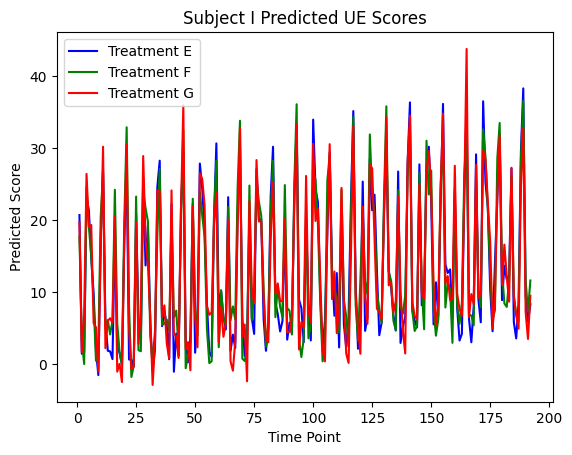

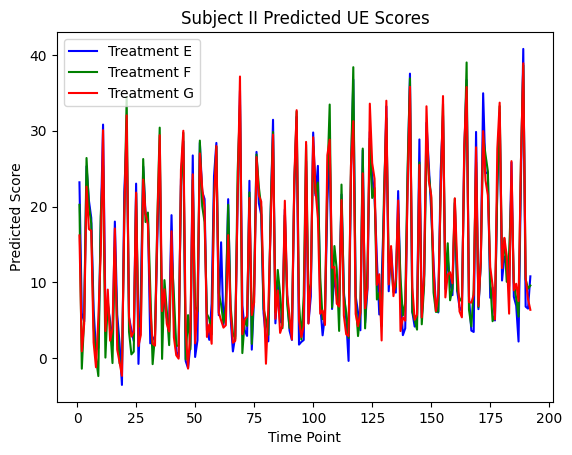

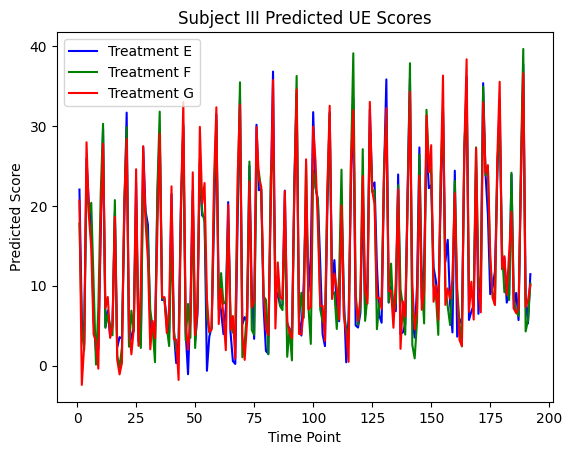

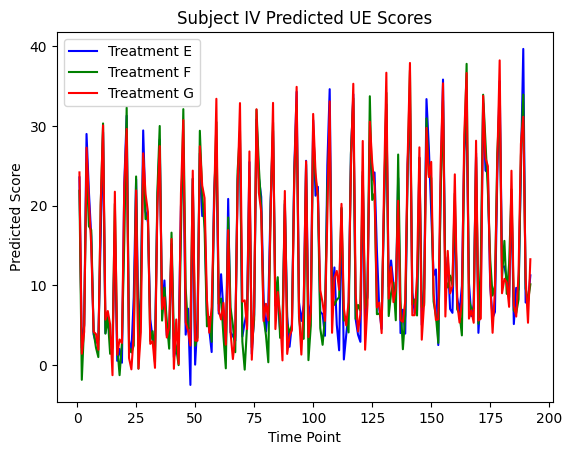

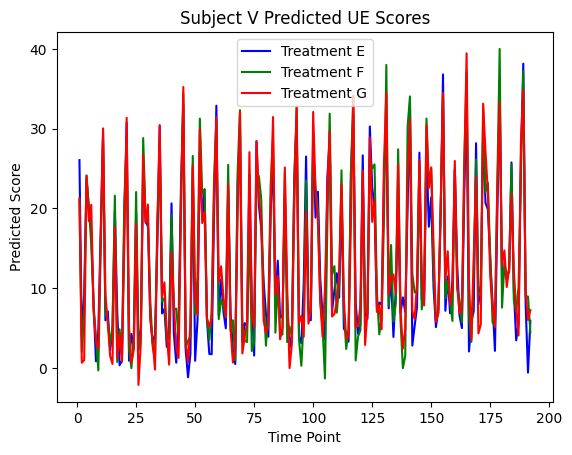

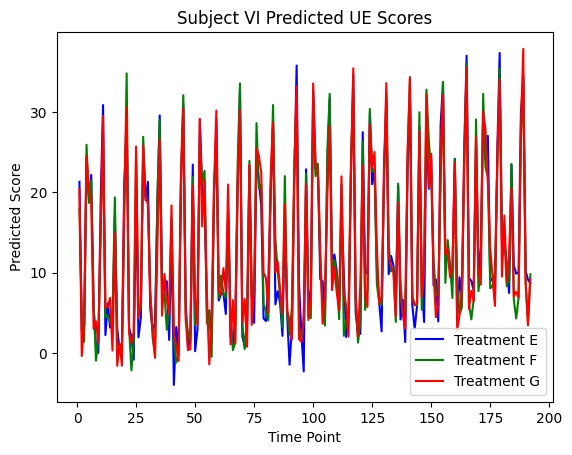

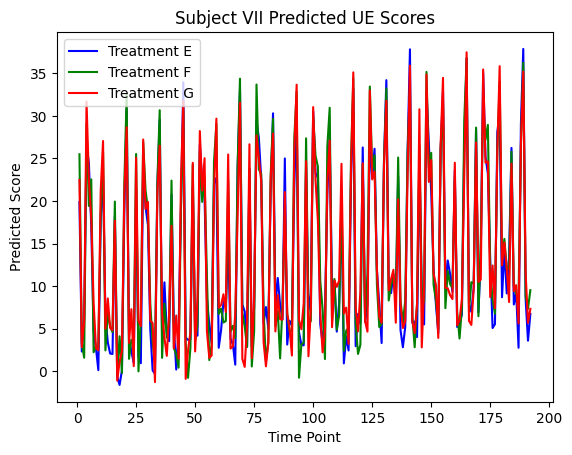

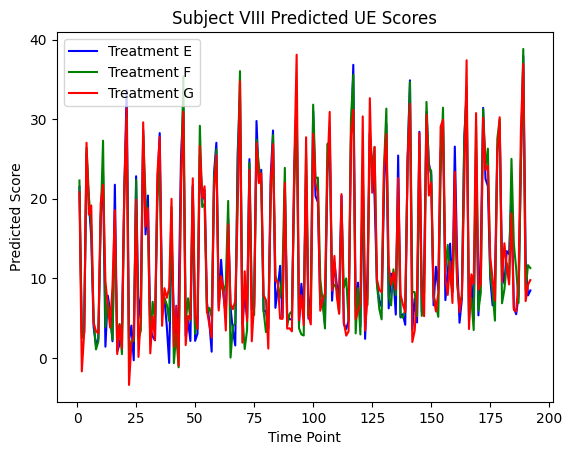

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(subjects_df, mean_scores_dict):
    subjects = subjects_df[subjects_df['Group'] == 'E']['Subject'].unique()

    for subject in subjects:
        plt.figure()
        subject_index = np.where(subjects_df['Subject'] == subject)[0][0]
        for treatment, color in zip(['E', 'F', 'G'], ['blue', 'green', 'red']):
            mean_scores = mean_scores_dict[treatment][subject_index, :]

            time_points = np.arange(1, mean_scores.shape[0] + 1)

            plt.plot(time_points, mean_scores, label=f'Treatment {treatment}', color=color)

        plt.title(f'Subject {subject} Predicted UE Scores')
        plt.xlabel('Time Point')
        plt.ylabel('Predicted Score')
        plt.legend()
        plt.show()

mean_scores_E, _, _ = predict_group_effect(long_df, 'E', hierarchical_model_UE, UE_trace)
mean_scores_F, _, _ = predict_group_effect(long_df, 'F', hierarchical_model_UE, UE_trace)
mean_scores_G, _, _ = predict_group_effect(long_df, 'G', hierarchical_model_UE, UE_trace)

mean_scores_dict = {
    'E': mean_scores_E,
    'F': mean_scores_F,
    'G': mean_scores_G
}

visualize_predictions(long_df, mean_scores_dict)

KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 55.88 ... 53.16
Attributes:
    created_at:                 2024-04-02T14:08:22.155089
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 44.01 ... 49.5
Attributes:
    created_at:                 2024-04-02T14:08:22.634989
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 51.01 ... 47.83
Attributes:
    created_at:                 2024-04-02T14:08:23.126261
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


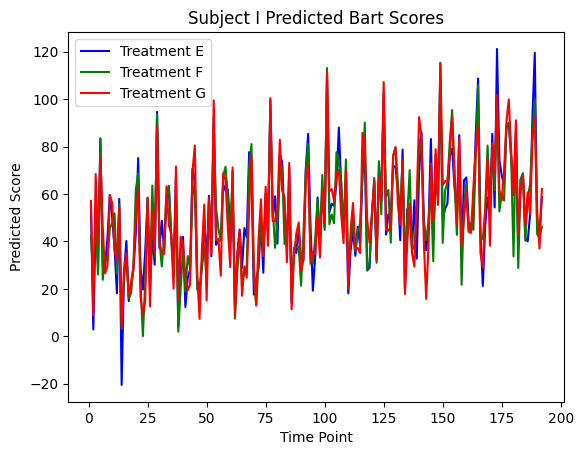

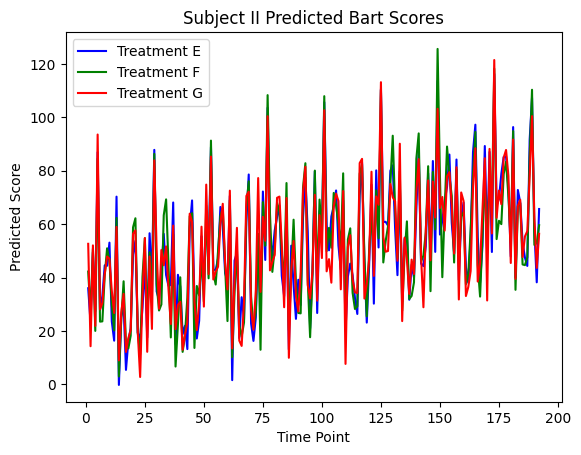

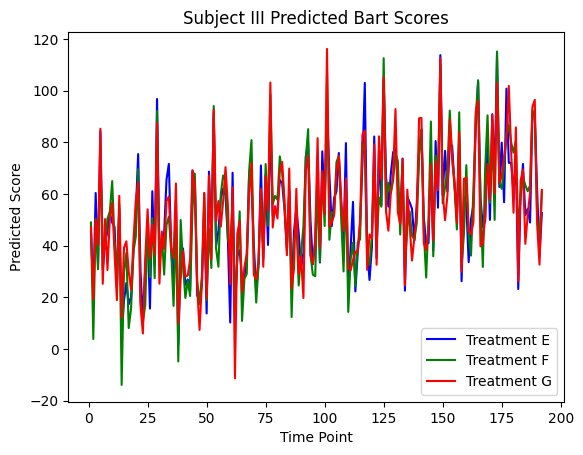

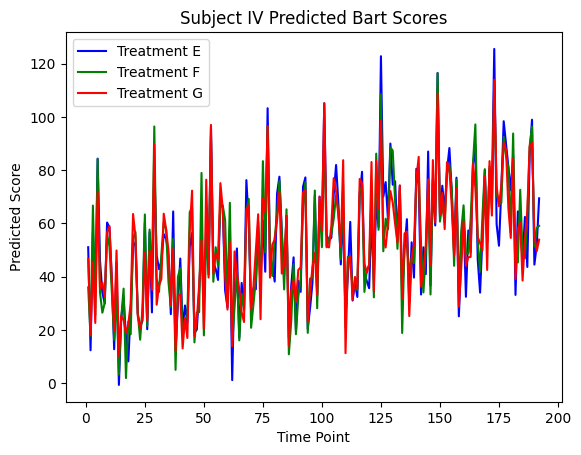

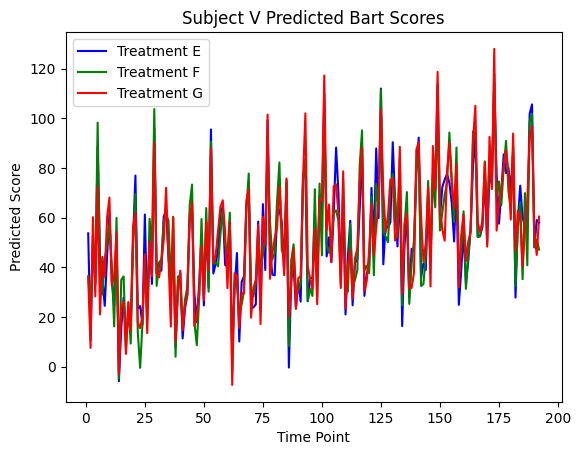

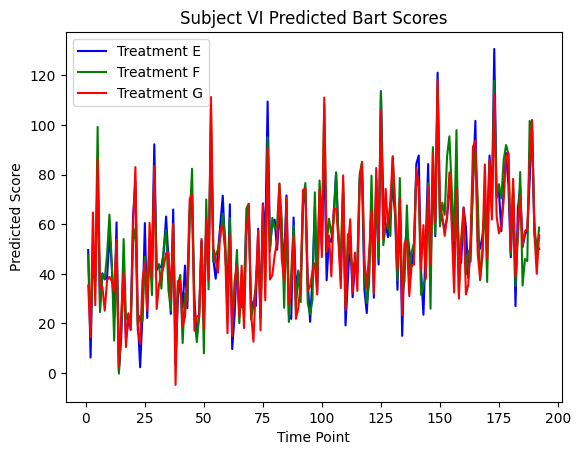

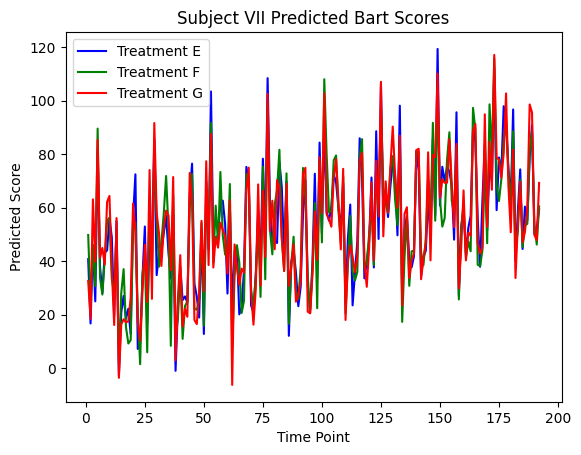

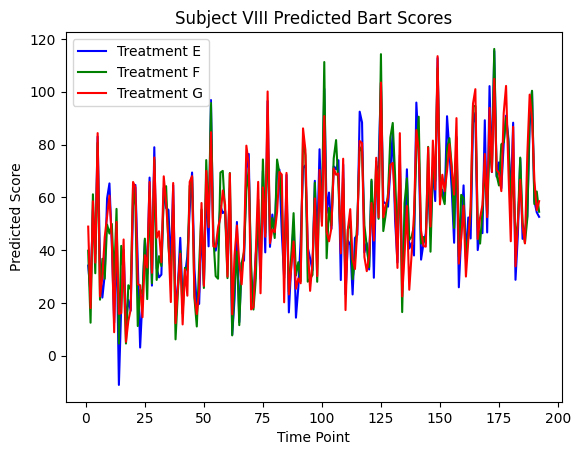

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(subjects_df, mean_scores_dict):
    subjects = subjects_df[subjects_df['Group'] == 'E']['Subject'].unique()

    for subject in subjects:
        plt.figure()
        subject_index = np.where(subjects_df['Subject'] == subject)[0][0]
        for treatment, color in zip(['E', 'F', 'G'], ['blue', 'green', 'red']):
            mean_scores = mean_scores_dict[treatment][subject_index, :]

            time_points = np.arange(1, mean_scores.shape[0] + 1)

            plt.plot(time_points, mean_scores, label=f'Treatment {treatment}', color=color)

        plt.title(f'Subject {subject} Predicted Bart Scores')
        plt.xlabel('Time Point')
        plt.ylabel('Predicted Score')
        plt.legend()
        plt.show()

mean_scores_E, _, _ = predict_group_effect(long_df, 'E', hierarchical_model_Bart, Bart_trace)
mean_scores_F, _, _ = predict_group_effect(long_df, 'F', hierarchical_model_Bart, Bart_trace)
mean_scores_G, _, _ = predict_group_effect(long_df, 'G', hierarchical_model_Bart, Bart_trace)

mean_scores_dict = {
    'E': mean_scores_E,
    'F': mean_scores_F,
    'G': mean_scores_G
}

visualize_predictions(long_df, mean_scores_dict)

KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 17.46 ... 9.954
Attributes:
    created_at:                 2024-04-02T14:23:57.162674
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 21.29 ... 13.66
Attributes:
    created_at:                 2024-04-02T14:23:57.655257
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 23.13 ... 13.09
Attributes:
    created_at:                 2024-04-02T14:23:58.160557
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


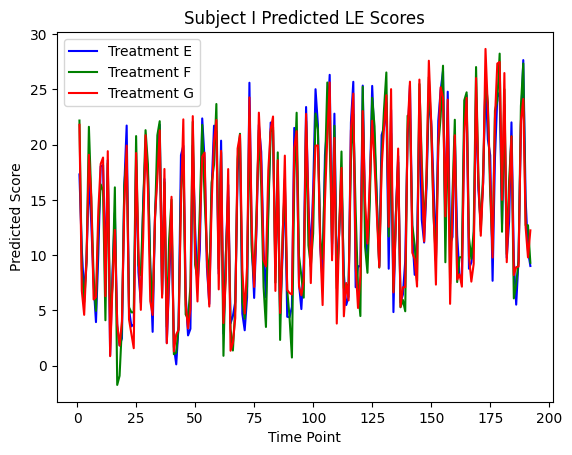

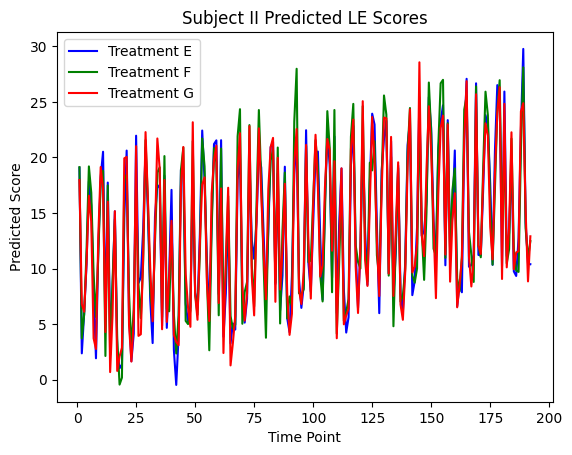

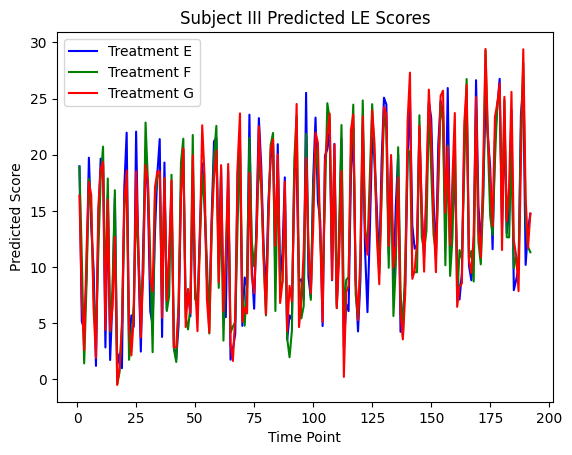

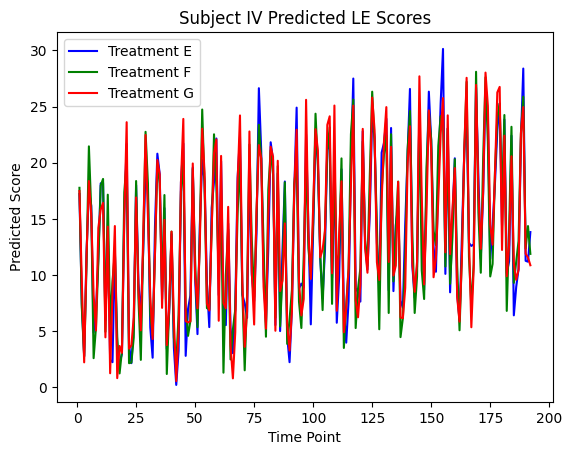

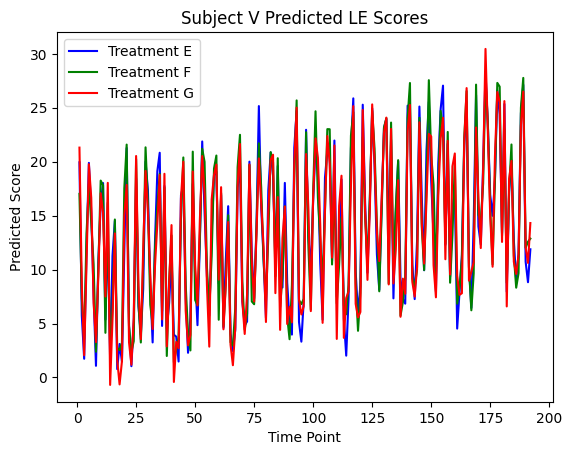

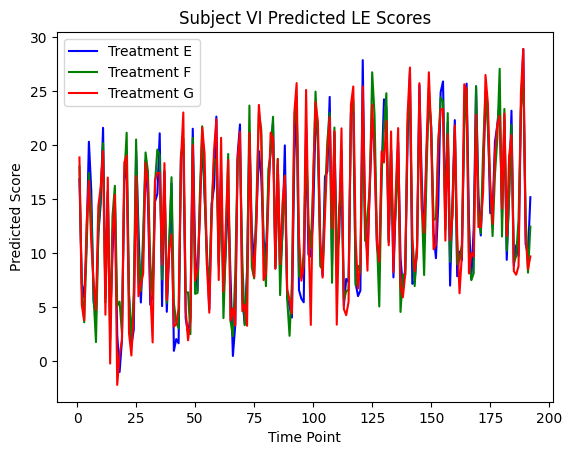

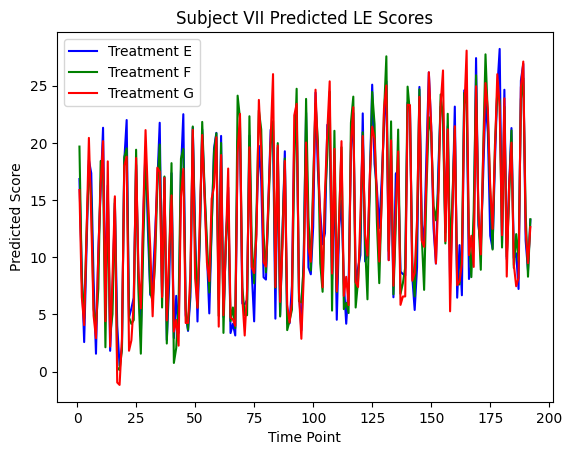

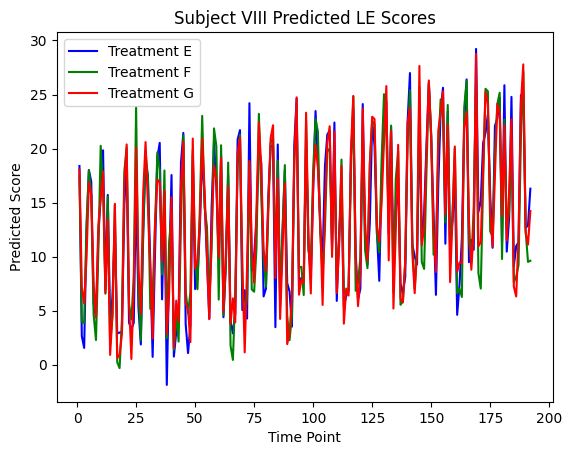

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(subjects_df, mean_scores_dict):
    subjects = subjects_df[subjects_df['Group'] == 'E']['Subject'].unique()

    for subject in subjects:
        plt.figure()
        subject_index = np.where(subjects_df['Subject'] == subject)[0][0]
        for treatment, color in zip(['E', 'F', 'G'], ['blue', 'green', 'red']):
            mean_scores = mean_scores_dict[treatment][subject_index, :]

            time_points = np.arange(1, mean_scores.shape[0] + 1)

            plt.plot(time_points, mean_scores, label=f'Treatment {treatment}', color=color)

        plt.title(f'Subject {subject} Predicted LE Scores')
        plt.xlabel('Time Point')
        plt.ylabel('Predicted Score')
        plt.legend()
        plt.show()

mean_scores_E, _, _ = predict_group_effect(long_df, 'E', hierarchical_model_LE, LE_trace)
mean_scores_F, _, _ = predict_group_effect(long_df, 'F', hierarchical_model_LE, LE_trace)
mean_scores_G, _, _ = predict_group_effect(long_df, 'G', hierarchical_model_LE, LE_trace)

mean_scores_dict = {
    'E': mean_scores_E,
    'F': mean_scores_F,
    'G': mean_scores_G
}

visualize_predictions(long_df, mean_scores_dict)

KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 7.927 ... 5.748
Attributes:
    created_at:                 2024-04-02T15:08:21.057924
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 6.111 ... 5.964
Attributes:
    created_at:                 2024-04-02T15:08:21.574060
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 4.256 ... 7.935
Attributes:
    created_at:                 2024-04-02T15:08:22.091748
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


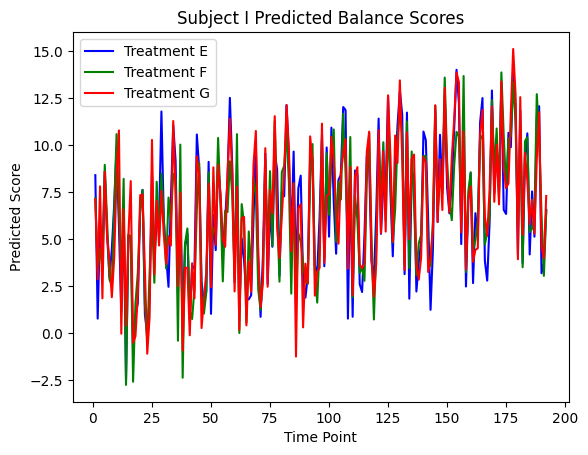

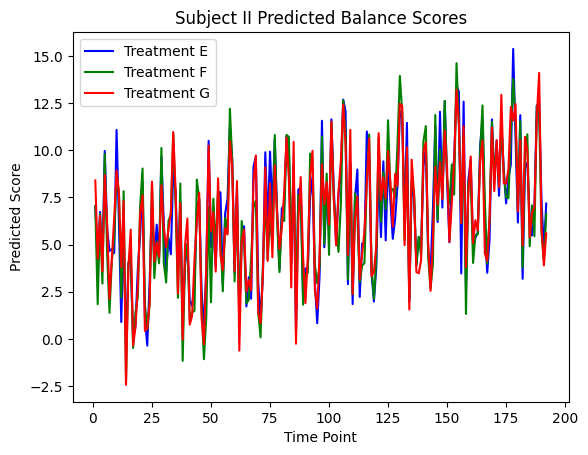

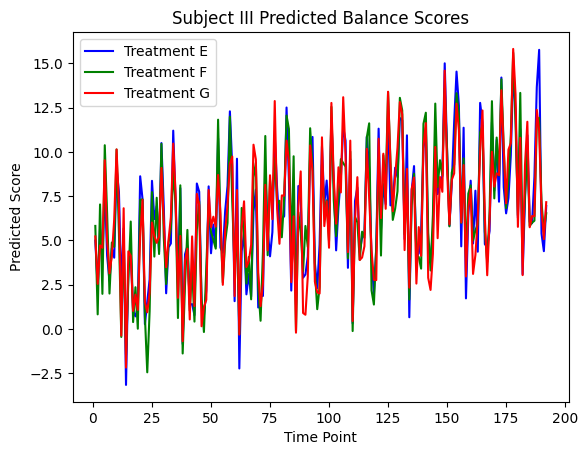

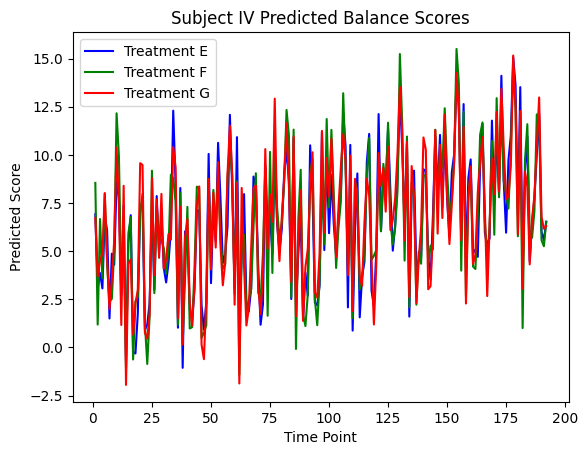

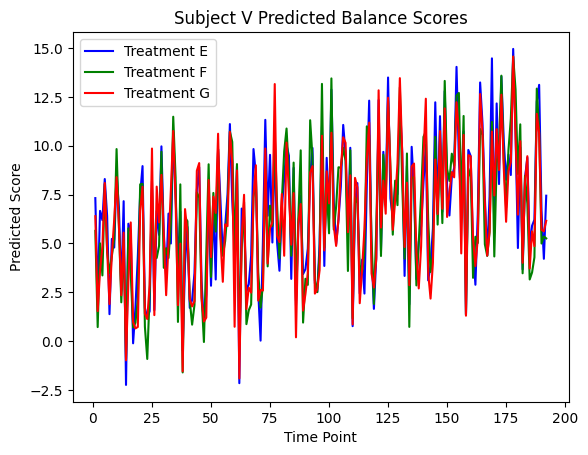

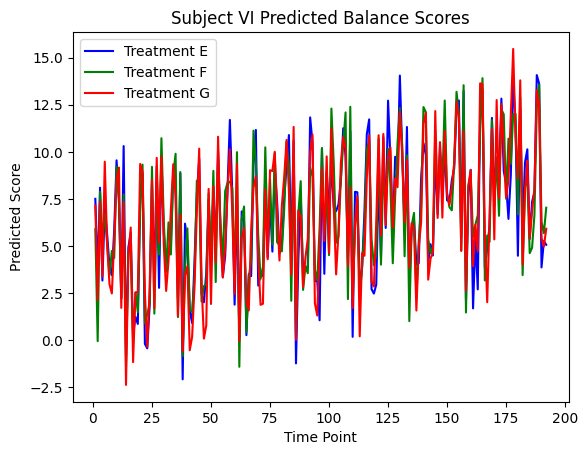

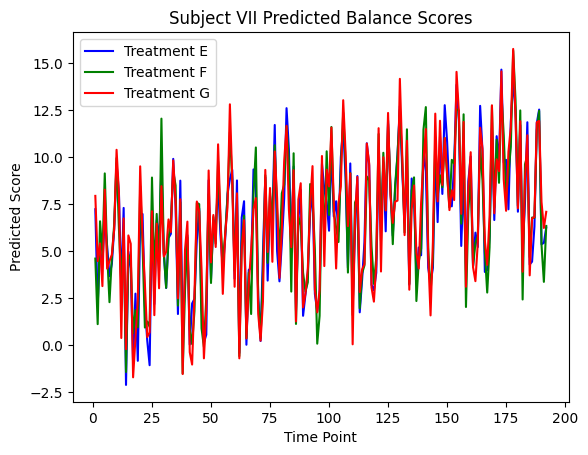

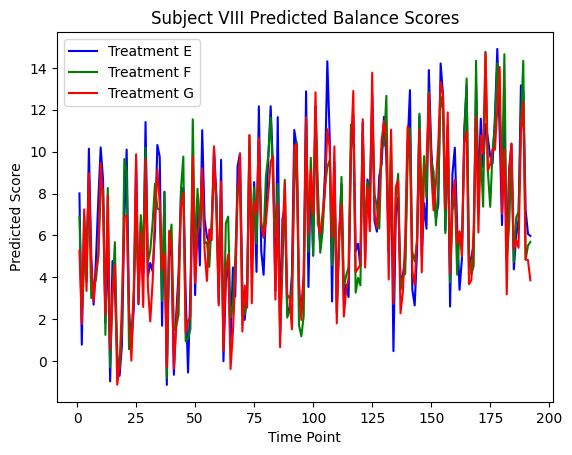

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(subjects_df, mean_scores_dict):
    subjects = subjects_df[subjects_df['Group'] == 'E']['Subject'].unique()

    for subject in subjects:
        plt.figure()
        subject_index = np.where(subjects_df['Subject'] == subject)[0][0]
        for treatment, color in zip(['E', 'F', 'G'], ['blue', 'green', 'red']):
            mean_scores = mean_scores_dict[treatment][subject_index, :]

            time_points = np.arange(1, mean_scores.shape[0] + 1)

            plt.plot(time_points, mean_scores, label=f'Treatment {treatment}', color=color)

        plt.title(f'Subject {subject} Predicted Balance Scores')
        plt.xlabel('Time Point')
        plt.ylabel('Predicted Score')
        plt.legend()
        plt.show()

mean_scores_E, _, _ = predict_group_effect(long_df, 'E', hierarchical_model_Bal, Bal_trace)
mean_scores_F, _, _ = predict_group_effect(long_df, 'F', hierarchical_model_Bal, Bal_trace)
mean_scores_G, _, _ = predict_group_effect(long_df, 'G', hierarchical_model_Bal, Bal_trace)

mean_scores_dict = {
    'E': mean_scores_E,
    'F': mean_scores_F,
    'G': mean_scores_G
}

visualize_predictions(long_df, mean_scores_dict)

# prediction of Week9

In [ ]:

week_8_data = long_df.copy()
week_9_data = week_8_data.copy()
week_9_data['Week'] = 9  # 将周数设置为9
week_9_data['UE'] = np.nan  # UE分数设置为缺失，因为我们想预测它
week_9_data


# 为模型中使用的变量定义一些索引变量
subject_idx = long_df['Subject'].astype('category').cat.codes.values


age = long_df['Age'].values
week = long_df['Week'].values
side_code = long_df['Side_code'].values
sex = long_df['Sex_code'].values
lapse = long_df['Lapse'].values
# change
ue_scores = long_df['UE'].values

n_subjects = len(long_df['Subject'].unique())

long_df['Group_code'] = long_df['Group'].astype('category').cat.codes.values
group_idx = long_df['Group_code'].values
n_groups = long_df['Group'].nunique()

# 更新模型数据
with hierarchical_model_UE:
    pm.set_data({'group_idx': week_9_data['Group_code'].values,
        'subject_idx': week_9_data['Subject'].astype('category').cat.codes.values,
        'week': week_9_data['Week'].values,
        'age': week_9_data['Age'].values,
        'sex': week_9_data['Sex_code'].values,
        'side_code': week_9_data['Side_code'].values,
        'lapse': week_9_data['Lapse'].values})

    # 进行后验预测
    posterior_predictive = pm.sample_posterior_predictive(UE_trace)

# 获取第九周UE分数的预测值
predicted_ue_scores = posterior_predictive.posterior_predictive['likelihood'].values
predicted_ue_scores
predicted_ue_scores_week_9 = predicted_ue_scores.mean(axis=0)[-len(week_9_data):]
predicted_ue_scores_week_9


import pandas as pd
import numpy as np

# Flatten the last dimension if necessary and then take the mean and percentiles
predicted_ue_scores_week_9 = predicted_ue_scores.reshape(-1, len(week_9_data))  # Reshape to combine chains and samples

# Calculate mean and percentiles for the predicted UE scores
mean_predicted_scores = np.mean(predicted_ue_scores_week_9, axis=0)
ci_lower = np.percentile(predicted_ue_scores_week_9, 2.5, axis=0)
ci_upper = np.percentile(predicted_ue_scores_week_9, 97.5, axis=0)

# Now we can safely assign the values to the DataFrame columns
week_9_data['Predicted_UE_Mean'] = mean_predicted_scores
week_9_data['Predicted_UE_Lower'] = ci_lower
week_9_data['Predicted_UE_Upper'] = ci_upper

# Create the final dataset with selected columns
predicted_scores_dataset = week_9_data[['Subject', 'Predicted_UE_Mean', 'Predicted_UE_Lower', 'Predicted_UE_Upper']]
predicted_scores_dataset

# Select and display rows where the 'Subject' column is 'IV'
predicted_scores_for_subject_IV = predicted_scores_dataset.loc[predicted_scores_dataset['Subject'] == 'IV']
predicted_scores_for_subject_IV

# Calculate the mean prediction and 95% confidence interval for Subject IV
predicted_ue_mean_iv = predicted_scores_dataset.loc[predicted_scores_dataset['Subject'] == 'IV', 'Predicted_UE_Mean'].mean()
predicted_ue_lower_iv = predicted_scores_dataset.loc[predicted_scores_dataset['Subject'] == 'IV', 'Predicted_UE_Lower'].mean()
predicted_ue_upper_iv = predicted_scores_dataset.loc[predicted_scores_dataset['Subject'] == 'IV', 'Predicted_UE_Upper'].mean()

# Create a summary DataFrame for Subject IV
summary_iv = pd.DataFrame({
    'Subject': 'IV',
    'Predicted_UE_Mean': [predicted_ue_mean_iv],
    'Predicted_UE_Lower': [predicted_ue_lower_iv],
    'Predicted_UE_Upper': [predicted_ue_upper_iv]
})

summary_iv



Subject  Predicted_UE_Mean  Predicted_UE_Lower  Predicted_UE_Upper
0      IV          33.033236           26.883203           39.237863

In [ ]:
# 假设 long_df 是你已经转换为长格式的原始数据框
# 获取第八周的数据来创建第九周的数据框架
#需要改成替换8
week_8_data = long_df.copy()
week_9_data = week_8_data.copy()
week_9_data['Week'] = 9  # 将周数设置为9
week_9_data['Bart'] = np.nan  # UE分数设置为缺失，因为我们想预测它
week_9_data


# 为模型中使用的变量定义一些索引变量
subject_idx = long_df['Subject'].astype('category').cat.codes.values


age = long_df['Age'].values
week = long_df['Week'].values
side_code = long_df['Side_code'].values
sex = long_df['Sex_code'].values
lapse = long_df['Lapse'].values
# change
Bart_scores = long_df['Bart'].values

n_subjects = len(long_df['Subject'].unique())

long_df['Group_code'] = long_df['Group'].astype('category').cat.codes.values
group_idx = long_df['Group_code'].values
n_groups = long_df['Group'].nunique()

# 更新模型数据
with hierarchical_model_UE:
    pm.set_data({'group_idx': week_9_data['Group_code'].values,
        'subject_idx': week_9_data['Subject'].astype('category').cat.codes.values,
        'week': week_9_data['Week'].values,
        'age': week_9_data['Age'].values,
        'sex': week_9_data['Sex_code'].values,
        'side_code': week_9_data['Side_code'].values,
        'lapse': week_9_data['Lapse'].values})

    # 进行后验预测
    posterior_predictive = pm.sample_posterior_predictive(Bart_trace)

# 获取第九周UE分数的预测值
predicted_ue_scores = posterior_predictive.posterior_predictive['likelihood'].values
predicted_ue_scores
predicted_ue_scores_week_9 = predicted_ue_scores.mean(axis=0)[-len(week_9_data):]
predicted_ue_scores_week_9


import pandas as pd
import numpy as np

# Flatten the last dimension if necessary and then take the mean and percentiles
predicted_ue_scores_week_9 = predicted_ue_scores.reshape(-1, len(week_9_data))  # Reshape to combine chains and samples

# Calculate mean and percentiles for the predicted UE scores
mean_predicted_scores = np.mean(predicted_ue_scores_week_9, axis=0)
ci_lower = np.percentile(predicted_ue_scores_week_9, 2.5, axis=0)
ci_upper = np.percentile(predicted_ue_scores_week_9, 97.5, axis=0)

# Now we can safely assign the values to the DataFrame columns
week_9_data['Predicted_Bart_Mean'] = mean_predicted_scores
week_9_data['Predicted_Bart_Lower'] = ci_lower
week_9_data['Predicted_Bart_Upper'] = ci_upper

# Create the final dataset with selected columns
predicted_scores_dataset = week_9_data[['Subject', 'Predicted_Bart_Mean', 'Predicted_Bart_Lower', 'Predicted_Bart_Upper']]
predicted_scores_dataset

# Select and display rows where the 'Subject' column is 'IV'
predicted_scores_for_subject_IV = predicted_scores_dataset.loc[predicted_scores_dataset['Subject'] == 'IV']
predicted_scores_for_subject_IV

# Calculate the mean prediction and 95% confidence interval for Subject IV
predicted_bart_mean_iv = predicted_scores_dataset.loc[predicted_scores_dataset['Subject'] == 'IV', 'Predicted_Bart_Mean'].mean()
predicted_bart_lower_iv = predicted_scores_dataset.loc[predicted_scores_dataset['Subject'] == 'IV', 'Predicted_Bart_Lower'].mean()
predicted_bart_upper_iv = predicted_scores_dataset.loc[predicted_scores_dataset['Subject'] == 'IV', 'Predicted_Bart_Upper'].mean()

# Create a summary DataFrame for Subject IV
summary_iv = pd.DataFrame({
    'Subject': 'IV',
    'Predicted_Bart_Mean': [predicted_bart_mean_iv],
    'Predicted_Bart_Lower': [predicted_bart_lower_iv],
    'Predicted_Bart_Upper': [predicted_bart_upper_iv]
})

summary_iv


Subject  Predicted_Bart_Mean  Predicted_Bart_Lower  Predicted_Bart_Upper
0      IV            70.473388             51.476586             89.641087

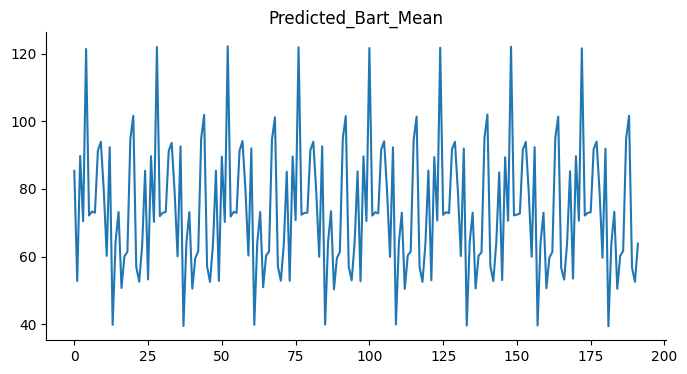

In [ ]:
# 假设 long_df 是你已经转换为长格式的原始数据框
# 获取第八周的数据来创建第九周的数据框架
#需要改成替换8
week_8_data = long_df.copy()
week_9_data = week_8_data.copy()
week_9_data['Week'] = 9  # 将周数设置为9
week_9_data['Bal'] = np.nan  # UE分数设置为缺失，因为我们想预测它
week_9_data


# 为模型中使用的变量定义一些索引变量
subject_idx = long_df['Subject'].astype('category').cat.codes.values


age = long_df['Age'].values
week = long_df['Week'].values
side_code = long_df['Side_code'].values
sex = long_df['Sex_code'].values
lapse = long_df['Lapse'].values
# change
Bal_scores = long_df['Bal'].values

n_subjects = len(long_df['Subject'].unique())

long_df['Group_code'] = long_df['Group'].astype('category').cat.codes.values
group_idx = long_df['Group_code'].values
n_groups = long_df['Group'].nunique()

# 更新模型数据
with hierarchical_model_UE:
    pm.set_data({'group_idx': week_9_data['Group_code'].values,
        'subject_idx': week_9_data['Subject'].astype('category').cat.codes.values,
        'week': week_9_data['Week'].values,
        'age': week_9_data['Age'].values,
        'sex': week_9_data['Sex_code'].values,
        'side_code': week_9_data['Side_code'].values,
        'lapse': week_9_data['Lapse'].values})

    # 进行后验预测
    posterior_predictive = pm.sample_posterior_predictive(Bal_trace)

# 获取第九周UE分数的预测值
predicted_ue_scores = posterior_predictive.posterior_predictive['likelihood'].values
predicted_ue_scores
predicted_ue_scores_week_9 = predicted_ue_scores.mean(axis=0)[-len(week_9_data):]
predicted_ue_scores_week_9


import pandas as pd
import numpy as np

# Flatten the last dimension if necessary and then take the mean and percentiles
predicted_ue_scores_week_9 = predicted_ue_scores.reshape(-1, len(week_9_data))  # Reshape to combine chains and samples

# Calculate mean and percentiles for the predicted UE scores
mean_predicted_scores = np.mean(predicted_ue_scores_week_9, axis=0)
ci_lower = np.percentile(predicted_ue_scores_week_9, 2.5, axis=0)
ci_upper = np.percentile(predicted_ue_scores_week_9, 97.5, axis=0)

# Now we can safely assign the values to the DataFrame columns
week_9_data['Predicted_Bal_Mean'] = mean_predicted_scores
week_9_data['Predicted_Bal_Lower'] = ci_lower
week_9_data['Predicted_Bal_Upper'] = ci_upper

# Create the final dataset with selected columns
predicted_scores_dataset = week_9_data[['Subject', 'Predicted_Bal_Mean', 'Predicted_Bal_Lower', 'Predicted_Bal_Upper']]
predicted_scores_dataset

# # Select and display rows where the 'Subject' column is 'IV'
# predicted_scores_for_subject_IV = predicted_scores_dataset.loc[predicted_scores_dataset['Subject'] == 'IV']
# predicted_scores_for_subject_IV

# # Calculate the mean prediction and 95% confidence interval for Subject IV
# predicted_bal_mean_iv = predicted_scores_dataset.loc[predicted_scores_dataset['Subject'] == 'IV', 'Predicted_Bal_Mean'].mean()
# predicted_bal_lower_iv = predicted_scores_dataset.loc[predicted_scores_dataset['Subject'] == 'IV', 'Predicted_Bal_Lower'].mean()
# predicted_bal_upper_iv = predicted_scores_dataset.loc[predicted_scores_dataset['Subject'] == 'IV', 'Predicted_Bal_Upper'].mean()



Subject  Predicted_Bal_Mean  Predicted_Bal_Lower  Predicted_Bal_Upper
0         I           12.627159             9.588137            15.694665
1        II            7.844130             5.029060            10.778091
2       III           11.405584             8.531298            14.357300
3        IV            9.082268             6.118686            12.071545
4         V           13.759060            10.773361            16.645144
..      ...                 ...                  ...                  ...
187       D           12.679927             9.704853            15.619271
188       E           12.873771            10.094517            15.904354
189       F            6.535135             3.642425             9.636570
190       G            5.393860             2.590122             8.467931
191       H            7.226272             4.255280            10.259281

[192 rows x 4 columns]

In [ ]:
# 假设 long_df 是你已经转换为长格式的原始数据框
# 获取第八周的数据来创建第九周的数据框架
#需要改成替换8
week_8_data = long_df.copy()
week_9_data = week_8_data.copy()
week_9_data['Week'] = 9  # 将周数设置为9
week_9_data['UE'] = np.nan  # UE分数设置为缺失，因为我们想预测它
week_9_data


# 为模型中使用的变量定义一些索引变量
subject_idx = long_df['Subject'].astype('category').cat.codes.values


age = long_df['Age'].values
week = long_df['Week'].values
side_code = long_df['Side_code'].values
sex = long_df['Sex_code'].values
lapse = long_df['Lapse'].values
# change
LE_scores = long_df['LE'].values

n_subjects = len(long_df['Subject'].unique())

long_df['Group_code'] = long_df['Group'].astype('category').cat.codes.values
group_idx = long_df['Group_code'].values
n_groups = long_df['Group'].nunique()

# 更新模型数据
with hierarchical_model_UE:
    pm.set_data({'group_idx': week_9_data['Group_code'].values,
        'subject_idx': week_9_data['Subject'].astype('category').cat.codes.values,
        'week': week_9_data['Week'].values,
        'age': week_9_data['Age'].values,
        'sex': week_9_data['Sex_code'].values,
        'side_code': week_9_data['Side_code'].values,
        'lapse': week_9_data['Lapse'].values})

    # 进行后验预测
    posterior_predictive = pm.sample_posterior_predictive(LE_trace)

# 获取第九周UE分数的预测值
predicted_ue_scores = posterior_predictive.posterior_predictive['likelihood'].values
predicted_ue_scores
predicted_ue_scores_week_9 = predicted_ue_scores.mean(axis=0)[-len(week_9_data):]
predicted_ue_scores_week_9


import pandas as pd
import numpy as np

# Flatten the last dimension if necessary and then take the mean and percentiles
predicted_ue_scores_week_9 = predicted_ue_scores.reshape(-1, len(week_9_data))  # Reshape to combine chains and samples

# Calculate mean and percentiles for the predicted UE scores
mean_predicted_scores = np.mean(predicted_ue_scores_week_9, axis=0)
ci_lower = np.percentile(predicted_ue_scores_week_9, 2.5, axis=0)
ci_upper = np.percentile(predicted_ue_scores_week_9, 97.5, axis=0)

# Now we can safely assign the values to the DataFrame columns
week_9_data['Predicted_LE_Mean'] = mean_predicted_scores
week_9_data['Predicted_LE_Lower'] = ci_lower
week_9_data['Predicted_LE_Upper'] = ci_upper

# Create the final dataset with selected columns
predicted_scores_dataset = week_9_data[['Subject', 'Predicted_LE_Mean', 'Predicted_LE_Lower', 'Predicted_LE_Upper']]
predicted_scores_dataset


# Select and display rows where the 'Subject' column is 'IV'
predicted_scores_for_subject_IV = predicted_scores_dataset.loc[predicted_scores_dataset['Subject'] == 'IV']
predicted_scores_for_subject_IV

# Calculate the mean prediction and 95% confidence interval for Subject IV
predicted_le_mean_iv = predicted_scores_dataset.loc[predicted_scores_dataset['Subject'] == 'IV', 'Predicted_LE_Mean'].mean()
predicted_le_lower_iv = predicted_scores_dataset.loc[predicted_scores_dataset['Subject'] == 'IV', 'Predicted_LE_Lower'].mean()
predicted_le_upper_iv = predicted_scores_dataset.loc[predicted_scores_dataset['Subject'] == 'IV', 'Predicted_LE_Upper'].mean()


In [ ]:
# Assuming 'predicted_bart_lower_iv', 'predicted_bart_upper_iv', etc. are already defined similarly
# as the means of their respective confidence intervals for Subject IV

# Create a summary DataFrame with all the scores for Subject IV
scores_summary_iv = pd.DataFrame({
    'Score_Type': ['UE', 'Bart', 'LE', 'Bal'],
    'Mean': [
        predicted_ue_mean_iv,
        predicted_bart_mean_iv,
        predicted_le_mean_iv,
        predicted_bal_mean_iv
    ],
    'Lower_CI': [
        predicted_ue_lower_iv,
        predicted_bart_lower_iv,
        predicted_le_lower_iv,
        predicted_bal_lower_iv
    ],
    'Upper_CI': [
        predicted_ue_upper_iv,
        predicted_bart_upper_iv,
        predicted_le_upper_iv,
        predicted_bal_upper_iv
    ]
})

# If you want to display the mean and CI as a list in one cell
scores_summary_iv['Mean_CI'] = scores_summary_iv.apply(
    lambda row: [row['Mean'], row['Lower_CI'], row['Upper_CI']], axis=1
)

# Select only the relevant columns for a cleaner table
final_table = scores_summary_iv[['Score_Type', 'Mean_CI']]
final_table


Score_Type                                                      Mean_CI
0         UE    [33.0332362004021, 26.883202714691315, 39.23786302999988]
1       Bart    [70.4733883180523, 51.476586090785716, 89.64108686512753]
2         LE  [19.30142219825516, 14.699869988629185, 23.897654842851637]
3        Bal    [9.051312997572309, 6.14882808386333, 12.009017885641576]

In [ ]:
# Format the 'Mean_CI' column to the specific string format
scores_summary_iv['Mean_CI'] = scores_summary_iv.apply(
    lambda row: f"{row['Mean']:.2f}[{row['Lower_CI']:.2f}, {row['Upper_CI']:.2f}]", axis=1
)

# Now we have a formatted 'Mean_CI' column, we can display the table
final_table_formatted = scores_summary_iv[['Score_Type', 'Mean_CI']]

# To display the entire DataFrame without truncation for screenshot
pd.set_option('display.max_columns', None)  # Replace 'None' with the number of your columns if known
pd.set_option('display.max_colwidth', None)

# Now print the DataFrame
print(final_table_formatted.to_string(index=False))


Score_Type             Mean_CI
        UE 33.03[26.88, 39.24]
      Bart 70.47[51.48, 89.64]
        LE 19.30[14.70, 23.90]
       Bal   9.05[6.15, 12.01]
